# Assignment #4

READ ALL INSTRUCTIONS CAREFULLY

This assignment is a puzzle. You have been given a data set with some semi-informative column headers but no additional information about it. Your goal is to investigate the data, understand as much about it as you can, and report back what you find.

You are free to use any and all of the techniques we have covered this semester: EDA, data wrangling, visualization (scatter plots, line plots, histograms, jointplots, etc.), descriptive statistics (mean, median, variance, covariance, etc.), regression / model fitting, loss functions (MSE, MAE), R^2, cross-validation, bootstrapping, gradient descent, etc... 

There are many different ways to approach this assignment and be successful. I recommend starting simple and getting slowly more sophisticated as needed.

## Collaborators

You must work in groups of 2-3. You cannot work on this assignment alone. Your partners cannot be anyone you have partnered with previously on an assignment and they cannot be in your group for the semester project.

**Names of all collaborators go here** (including yourself):     
Janae Farinas   
Alex Vo     
Kristen Waterford

## Tools

You are not allowed to use LLMs (including the LLM results that pop up in Google search). You may use search online for ideas, use StackExchange, and I highly encourage using Python library documentation.

Hint: It may be useful to use the sklearn library for model fitting (and not to implement model fitting or optimization by hand).

## Submission Instructions

You must submit two files. One is your **Jupyter notebook** that you use to explore and analyze the data. The second file is a separate **PDF** reporting, presenting, and explaining your results with no code in it.

**Only one person** in your group should submit the assignment files on Canvas. Be sure everyone's names are listed under collaborators in both the notebook and the PDF so everyone gets credit!

## Potentially Helpful Documentation


https://scikit-learn.org/stable/api/sklearn.model_selection.html

https://scikit-learn.org/stable/modules/linear_model.html

https://scikit-learn.org/stable/api/sklearn.metrics.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

# Your Code Below

## Imports and CoW

In [1023]:
# Add all of your import statements here. ONLY include the imports you actually use. There are useful tools in the scikit-learn library for regression and model fitting, but you are not required to use it. If you use it, you will need to install it into your virtual environment.

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error


In [1024]:
# Enforce Copy-on-Write (CoW) semantics here
pd.set_option("mode.copy_on_write", True)

## Project Folder Organization and File Reading

You must read in the given data file using relative paths, as shown in previous assignments. Organize your work to be in a project folder, with src and data subfolders. Place your solution notebook in the src folder, and the given data file in the data folder.

In [1025]:
# Read in the data file (using relative paths for reproducibility). It should be able to download your notebook, put it in the src folder of my project folder, and run it without changing anything.
cwd = Path().cwd() 
project_folder = cwd.parent 
dataset_path = Path('data/mystery.csv') 

file = project_folder / dataset_path #join the project folder with the dataset path

if not file.exists():
    raise FileNotFoundError(f"Dataset file not found: {file}")

ds = pd.read_csv(file, sep='|')

## Data Preprocessing   
When Dropping "invalid" columns, I made sure to go back to the data and check the rows that have -999.0 and other columns with these values were indeed dropped when we dropped the invalid x rowa.


In [1026]:
#--------Analyzing Data-------------
#ds.describe()
#print(ds.dtypes)
print(ds[['x', 'y','z','c']].describe())
print(ds[['d1','d2','d3','d4']].describe())
#print(ds['c'].unique())

#--------Clean Data------------------
#Drop rows deemed invalid (rows with column values of -999.0)
x_invalid = ds[ds['x'] == -999]
ds = ds.drop(ds[ds['x'] == -999].index) 

#print(ds[ds['c'] == -999]) #Checked all columns for -999.0 values



                 x            y            z            c
count  1854.000000  1854.000000  1854.000000  1854.000000
mean     44.702607    53.394344    35.514137     6.002157
std      70.720754    74.296663    68.185888     3.737760
min    -999.000000  -999.000000  -999.000000     0.000000
25%      35.862902    32.303485    37.941742     3.000000
50%      47.474927    57.428922    39.920321     6.000000
75%      62.189990    81.894692    42.012014     9.000000
max      93.248123   109.814680    48.870364    12.000000
                d1           d2           d3            d4
count  1854.000000  1854.000000  1854.000000   1854.000000
mean    138.298107     3.278987    33.312987  28604.297833
std     159.671681    79.173899    67.983135  26765.170592
min    -999.000000  -999.000000  -999.000000  -6575.228052
25%      24.969669   -28.312801    36.854105   4106.422132
50%     142.894013   -10.266625    37.698475  21852.839683
75%     252.666808    32.307670    38.592883  50220.331945
max   

## Analyzing Data   
Plotting d1-d4 against x, y, z to try and find any indication of a relationship between columns

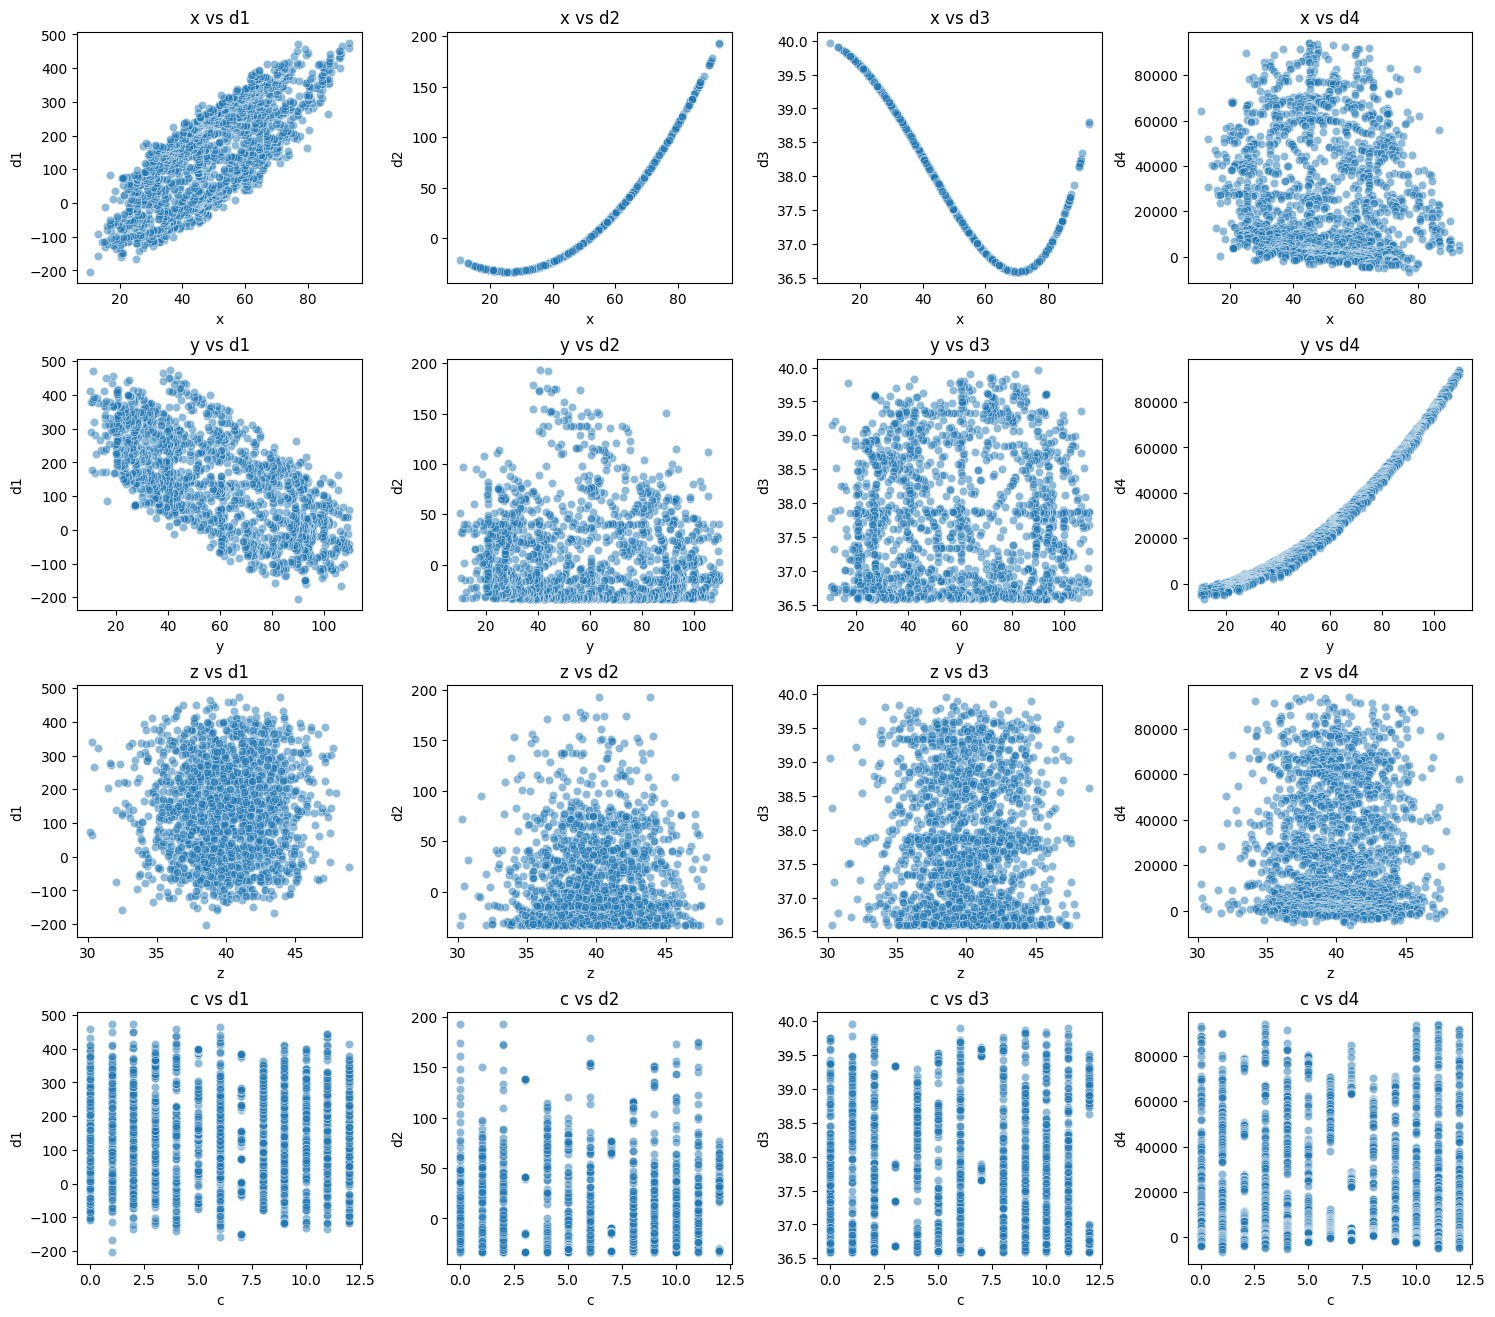

In [1027]:
xyzc = ['x', 'y', 'z', 'c']
d1_to_d4 = ['d1', 'd2', 'd3', 'd4']

#When displaying plots, compare with x,y,z being row and d1-d4 being col
#I want to display eveything side by side for easy comparison
fig, ax = plt.subplots(4, 4, figsize=(18, 16))

#print
for i in range(len(xyzc)):      
    for j in range(len(d1_to_d4)):  
        row = xyzc[i]
        col = d1_to_d4[j]

        sns.scatterplot(x=ds[row], y=ds[col], ax=ax[i, j], alpha=0.5)
        ax[i, j].set_xlabel(row)
        ax[i, j].set_ylabel(col)
        ax[i, j].set_title(f"{row} vs {col}")

plt.subplots_adjust(wspace = 0.3, hspace=0.3) 
plt.show()

### Data Observations
*   x seems to hold a strong relationship with both d2 and d3. x also seems to have the best relationship with d1   
*   y appears to hold the best relationship when plotted against d4 and some downward relationship with d1
*   z does not appear to have relationships with the values from d1-d4 as they seem to appear to us as random noise.
*   c may be categorical

NOTE: Initial Idea of partial derivatives in relation to gradients from column names might not seem to be the best course of testing

## Analyzing Relationships  
### x vs y against d1

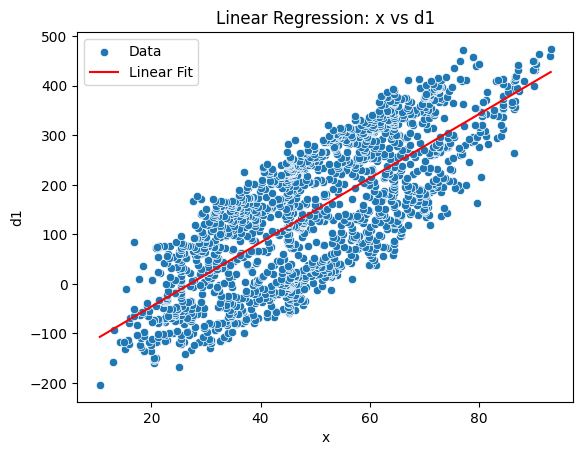

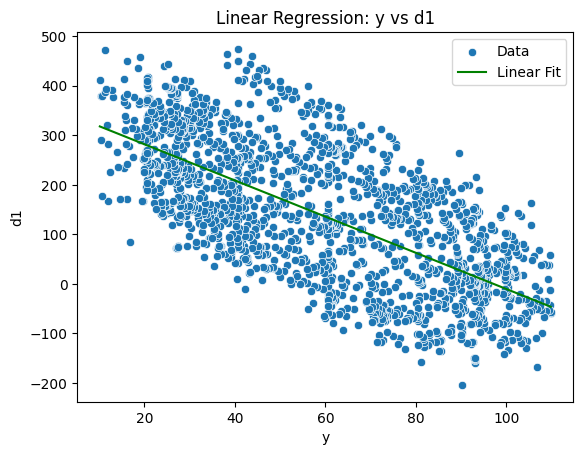

In [1028]:
#-----------------Linear Regression for (x vs d1) and (y vs d1) which presented strong linear relastionships --------------------------
model = LinearRegression().fit(ds[['x']], ds['d1'])
model2 = LinearRegression().fit(ds[['y']], ds['d1'])

sns.scatterplot(x=ds['x'], y=ds['d1'], label='Data')
sns.lineplot(x=ds['x'], y=model.predict(ds[['x']]), color='red', label='Linear Fit')
plt.xlabel('x')
plt.ylabel('d1')
plt.title('Linear Regression: x vs d1')
plt.legend()
plt.show()

sns.scatterplot(x=ds['y'], y=ds['d1'], label='Data')
sns.lineplot(x=ds['y'], y=model2.predict(ds[['y']]), color='green', label='Linear Fit')
plt.xlabel('y')
plt.ylabel('d1')
plt.title('Linear Regression: y vs d1')
plt.legend()
plt.show()

#-----------------Combining x,y,z to gain better insight on d1, d1 maintains linearity but direction seems dependent on either y or x incr/decr --------------------------

X = ds[['x', 'y', 'z']]
y_new = ds['d1']
model3 = LinearRegression().fit(X, y_new)
y_pred = model3.predict(X)
# print("MSE:", mean_squared_error(y_new, y_pred))
# print("R^2:", r2_score(y_new, y_pred))

# ---------------- We learned from prev assignment that intercepts have a great importance for accurate linear regressions
#----------------- The coeff will help tell the correlation between d1 and x,y, and z. 
# print("Intercept:", model3.intercept_)
# print("Coefficients:", model3.coef_)

### For d2, use Polynomial regression


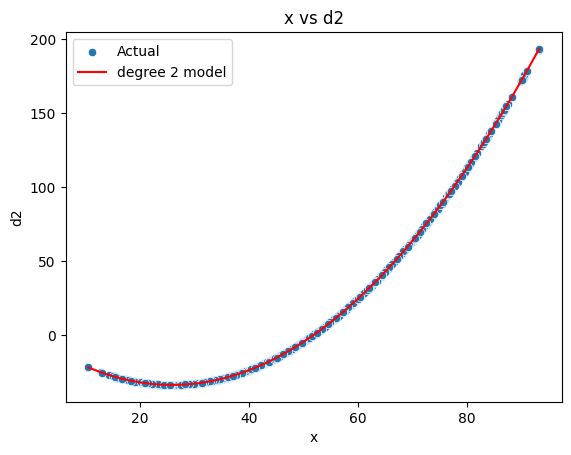

In [1029]:
#--------------------d2 observations 
# print(ds[['x', 'y', 'z', 'd2']].corr()['d2'])

poly = PolynomialFeatures(degree=2)
polyx = poly.fit_transform(ds[['x']])
poly_model = LinearRegression().fit(polyx, ds['d2'])

y_pred4poly = poly_model.predict(polyx)
# print("Intercept:", poly_model.intercept_)
# print("Coefficients:", poly_model.coef_)

sns.scatterplot(x=ds['x'], y=ds['d2'], label='Actual')
sns.lineplot(x=ds['x'], y=y_pred4poly, color='red', label='degree 2 model')
plt.title("x vs d2")
plt.legend()
plt.show()


### d3: Apply same process of fitting with higher degree polynomial because data shows a tend of 2 curvatures

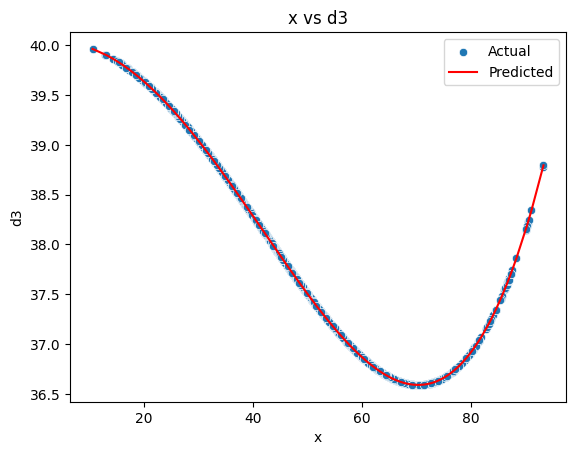

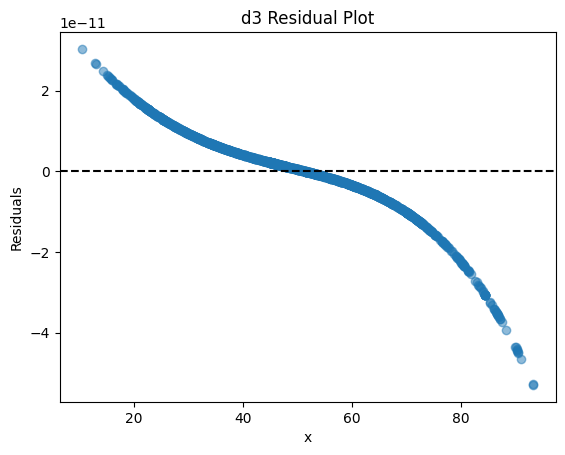

R^2: 1.0
MSE: 1.0364215496999636e-22


In [1030]:
#-----------------d3--------------------
X = ds['x'].to_numpy().reshape(-1, 1)    #reshape to np 2D array to fit input size for transform function (Errors told me this and it worked :D)

poly3 = PolynomialFeatures(degree=4)
X_poly3 = poly3.fit_transform(X)

model_d3 = LinearRegression()   #Now use transformed features to fit model
model_d3.fit(X_poly3, ds['d3'])
yhat_d3 = model_d3.predict(X_poly3)

#plot with model
plt.title("x vs d3")
sns.scatterplot(x=ds['x'], y=ds['d3'], label='Actual')

sns.lineplot(x=ds['x'], y=yhat_d3, color='red', label='Predicted')
plt.legend()

#---------------Plot d3 residuals---------
plt.figure() 
plt.xlabel('x') 
plt.ylabel('Residuals') 
plt.title('d3 Residual Plot') 

residuals = ds['d3'] - yhat_d3 

plt.scatter(ds['x'], residuals, alpha=0.5) 
plt.axhline(color='black', linestyle='--') 
plt.show()

#------------------Error checking-----------
r2_d3 = r2_score(ds['d3'], model_d3.predict(X_poly3))
print("R^2:", r2_d3)

mse_d3 = mean_squared_error(ds['d3'], yhat_d3)
print("MSE:", mse_d3)

From our model, we can see that d3 is derived from x and when we plot the residuals, the errors in the residual plot are so small that we decided to discard it and conclude it is a fit model for understanding the relationship between it and x

We have thought about the possibility of overfitting and missing information since the residual plot shows a pattern but we believe a model that closely predicts the trend is necessary for us to understand the data.


## d4 Observations

NOTE: I tried to do something with transforming it into the log scale since it looked logarithmic but the plot was not linear so I removed it to avoid confusion. The attempt below to fot a model with degree2 polynomial worked much better and gave us an idea of the data

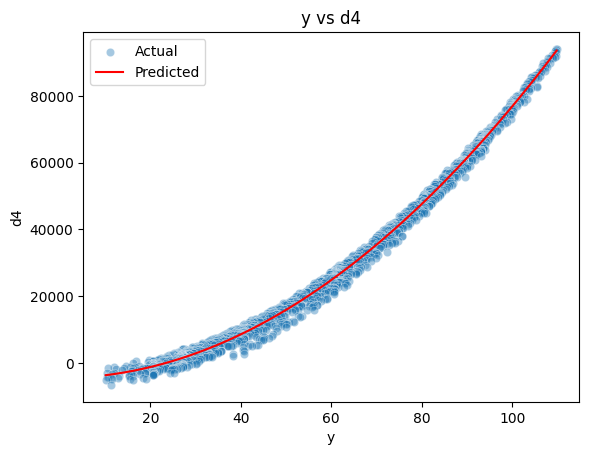

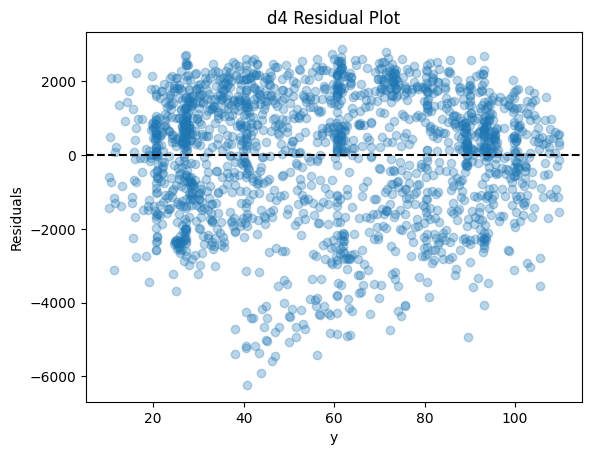

R^2: 0.9958340669951458
MSE: 2979794.067958646


In [1031]:
#-----------------d4-----------------------
Y = ds['y'].to_numpy().reshape(-1, 1)  

#d4 has the best relationship with y column so we use it in our model
poly4 = PolynomialFeatures(degree=2)
Y_poly = poly4.fit_transform(Y) 
model_d4 = LinearRegression()

model_d4.fit(Y_poly, ds['d4'])
yhat_d4 = model_d4.predict(Y_poly)

#plot
plt.title("y vs d4")
sns.scatterplot(x=ds['y'], y=ds['d4'], label='Actual', alpha=0.4)

sns.lineplot(x=ds['y'], y=yhat_d4, color='red', label='Predicted')
plt.legend()

#-----------------Plot residuals--------------
plt.figure() 
plt.xlabel('y') 
plt.ylabel('Residuals') 
plt.title('d4 Residual Plot') 

residuals = ds['d4'] - yhat_d4 

plt.scatter(ds['y'], residuals, alpha=0.3) 
plt.axhline(color='black', linestyle='--') 
plt.show()

#__________________Error checking--------------
r2_d4 = r2_score(ds['d4'], model_d4.predict(Y_poly))
print("R^2:", r2_d4)

mse_d4 = mean_squared_error(ds['d4'], yhat_d4)
print("MSE:", mse_d4)

#-----------------Testing---------------------
# num_rows = ds.shape[0]
# print("Number of rows:", num_rows)
